In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import context_inference
from pyhf_pymc import one_line_inference
from pyhf_pymc import make_op
from pyhf_pymc import plotting

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

In [2]:
blue = '#1F449C'
orange = '#E57A77'

plt.rc('font', size=18)      
plt.rc('axes', titlesize=18)   
plt.rc('axes', labelsize=18)   
plt.rc('xtick', labelsize=18)   
plt.rc('ytick', labelsize=18)    
plt.rc('legend', fontsize=15)    
plt.rc('figure', titlesize=18)

## Model

In [3]:
nBins = 3
model = pyhf.simplemodels.correlated_background([10]*nBins,[50]*nBins,[55]*nBins,[45]*nBins)

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}

obs = model.expected_actualdata([0., 2.])

prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, priors=prior_dict)

In [4]:
expData_op = make_op.make_op(model)

In [4]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data = pm.sample(draws=100, chains = 1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


### Prior and Posterior Predictives

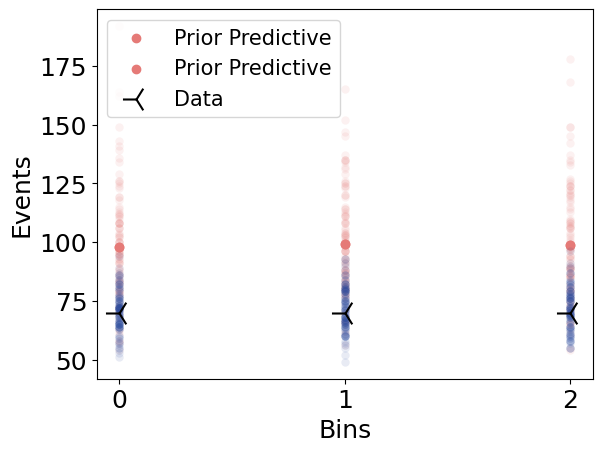

In [6]:
plotting.prior_posterior_predictives(model=model, observed=[70, 70, 70], post_pred=post_pred, prior_pred=prior_pred)

### Corner Plots

In [9]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data = pm.sample(10_000, chains = 1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


In [ ]:
my_range = [(-5, 5), (0, 16)]
my_bins = [25, 25]

a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, title_fmt=None, color=orange, labels=['', ''], bins=my_bins, range=my_range)
corner.corner(post_data.posterior, quantiles=[0.5], color = blue, truths=[0., 2.], truth_color='grey', bins=[25, 25], fig=a, labels=['Correlated background', 'Signal strength'], range=my_range)
a.suptitle('Prior and Posterior Parameter Distributions')

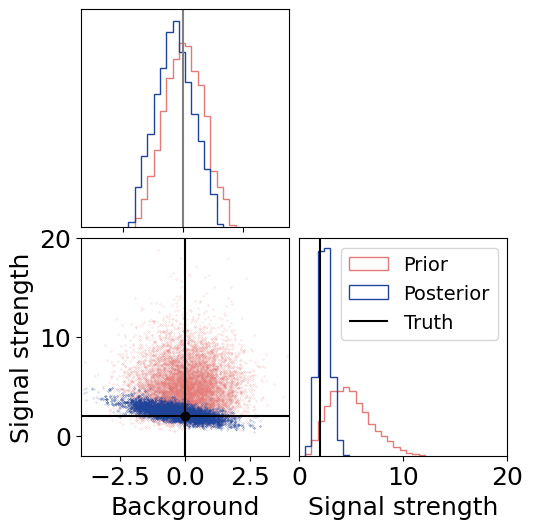

In [10]:
yrange = (0, 13_000)

fig, axs = plt.subplots(2, 2, figsize=(5.5, 5.8))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
# fig.suptitle('Prior and Posterior Parameter Distributions')
axs[0, 1].remove()

ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax3 = axs[1, 1]

# Normals Histogram
ax1.hist(prior_pred.prior.Normals[0], bins=30, histtype='step', color=orange)
_, bins, _ = ax1.hist(prior_pred.prior.Normals[0], bins=30, histtype='step', color=orange, alpha=0.000001)
ax1.hist(post_data.posterior.Normals[0], bins=bins, histtype='step', color=blue)
ax1.set_ylim(130)
ax1.vlines(0, 0, 13_000, color='grey')
ax1.set_yticks([])


# Scatter Plot
ax2.scatter(prior_pred.prior.Normals[0], prior_pred.prior.Unconstrained[0], alpha=0.6, s=0.04, color=orange)
ax2.scatter(post_data.posterior.Normals[0], post_data.posterior.Unconstrained[0], alpha=0.6, s=0.04, color=blue)
ax2.vlines(0, -2, 30, color='black')
ax2.set_ylim(-2, 20)
ax2.hlines(2, -6, 6, color='black')
ax2.set_xlim(-4, 4)
ax2.scatter(0, 2, color='black')
ax2.set_xlabel('Background')
ax2.set_ylabel('Signal strength')

# Unconstrained Histogram
ax3.hist(prior_pred.prior.Unconstrained[0], bins=30, histtype='step', color=orange, label='Prior')
_, bins, _ = ax3.hist(prior_pred.prior.Unconstrained[0], bins=30, histtype='step', color=orange, alpha=0.000001)
ax3.hist(post_data.posterior.Unconstrained[0], bins=bins, histtype='step', color=blue, label='Posterior')
ax3.set_yticks([])
ax3.set_xticks([0, 10, 20])
ax3.set_ylim(30)
ax3.set_xlim(0)
ax3.vlines(2, 0, 13_000, color='black', label='Truth')
ax3.set_xlabel('Signal strength')
plt.rc('legend', fontsize=14)  
ax3.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

  

### Calibration

In [11]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    prior_pred = pm.sample_prior_predictive(3000)

prior_Normals, prior_Unconstrained, prior_data = np.concatenate(prior_pred.prior.Normals[0]), np.concatenate(prior_pred.prior.Unconstrained[0]), np.array(prior_pred.prior_predictive.Expected_Data[0])

Sampling: [Expected_Data, Normals, Unconstrained]


In [12]:
with open('prior_Normals_Metropolis.txt', 'w') as filehandle:
    json.dump(prior_Normals.tolist(), filehandle)
with open('prior_Unconstrained_Metropolis.txt', 'w') as filehandle:
    json.dump(prior_Unconstrained.tolist(), filehandle)

In [ ]:
# post_Normals, post_Unconstrained, post_data = plotting.calibration(prepared_model, prior_pred)

In [16]:
def posterior_from_prior(prior_data):
        with pm.Model() as m:
                pars = prepare_inference.priors2pymc(prepared_model)
                Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars), observed=prior_data)
                
                step1 = pm.Metropolis()
                post_data = pm.sample(1, chains=1, step=step1, tune=1000)
                post_pred = pm.sample_posterior_predictive(post_data)

        return np.concatenate(post_data.posterior.Normals[0]), np.concatenate(post_data.posterior.Unconstrained[0]), np.array(post_pred.posterior_predictive.Expected_Data[0][0])

In [17]:
post_Normals, post_Unconstrained, post_data = [], [], []
i = 0
for p_d in prior_data:
    a, b, c = posterior_from_prior(p_d)
    post_Normals.append(a[0])
    post_Unconstrained.append(b[0])
    post_data.append(c[0])

    with open('post_Normals_Metropolis.txt', 'a') as file:
        file.write(f'{post_Normals[i]}, ')

    with open('post_Unconstrained_Metropolis.txt', 'a') as file:
        file.write(f'{post_Unconstrained[i]}, ')

    print(f'STEP: {i}')
    i += 1

Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2313


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2314


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2315


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2316


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2317


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2318


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2319


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2320


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2321


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2322


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2323


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2324


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2325


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2326


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2327


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2328


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2329


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2330


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2331


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2332


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2333


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2334


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2335


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2336


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2337


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2338


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2339


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2340


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2341


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2342


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2343


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2344


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2345


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2346


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2347


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2348


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2349


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2350


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2351


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2352


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2353


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2354


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2355


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2356


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2357


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2358


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2359


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2360


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2361


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2362


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2363


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2364


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2365


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2366


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2367


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2368


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2369


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2370


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2371


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2372


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2373


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2374


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2375


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2376


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2377


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2378


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2379


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2380


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2381


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2382


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2383


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2384


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2385


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2386


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2387


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2388


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2389


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2390


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2391


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2392


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2393


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2394


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2395


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2396


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2397


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2398


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2399


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2400


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2401


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2402


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2403


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2404


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2405


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2406


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2407


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2408


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2409


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2410


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2411


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2412


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2413


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2414


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2415


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2416


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2417


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2418


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2419


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2420


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2421


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2422


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2423


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2424


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2425


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2426


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2427


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2428


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2429


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2430


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2431


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2432


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2433


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2434


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2435


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2436


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2437


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2438


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2439


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2440


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2441


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2442


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2443


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2444


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2445


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2446


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2447


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2448


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2449


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2450


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2451


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2452


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2453


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2454


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2455


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2456


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2457


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 2458


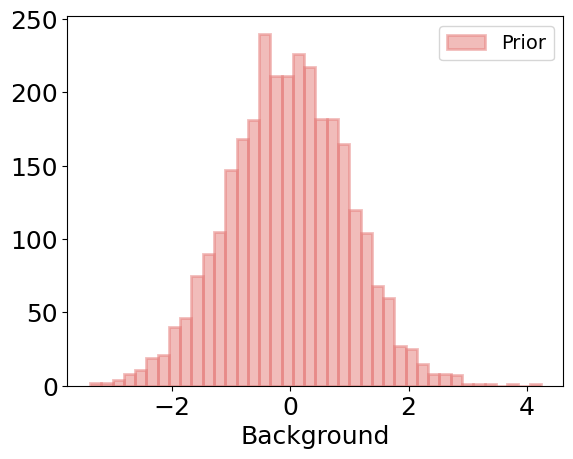

In [13]:
# Plot Normals
plt.hist(prior_Normals, 40, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Normals, bins=40, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Normals, bins = bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Background')
plt.ylabel('Number of draws?????')

plt.legend()


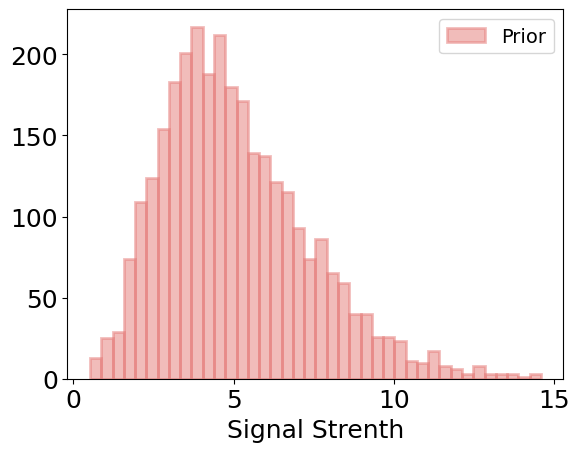

In [14]:
# Plot Unconstrained 
plt.hist(prior_Unconstrained, 40, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Unconstrained, bins=40, histtype='step', color=orange, alpha=0.000001)
# plt.hist(post_Unconstrained, bins=bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Signal Strenth')
plt.ylabel('Number of draws?????')

plt.legend()

plt.show()

## Autocorrelation

In [5]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data_MH = pm.sample(100, chains = 1, step=step)

with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data_MH_thinned = pm.sample(1200, chains = 1, step=step)

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Sampling 1 chain for 1_000 tune and 1_200 draw iterations (1_000 + 1_200 draws total) took 0 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (1200) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [6]:
with context_inference.pyhf_model(prepared_model):
    post_data_NUTS = pm.sample(100, chains = 1)

with context_inference.pyhf_model(prepared_model):
    post_data_NUTS_thinned = pm.sample(600, chains = 1)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 600 draw iterations (1_000 + 600 draws total) took 1 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (600) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [7]:
thinned_MH = post_data_MH_thinned.posterior.thin(12)
thinned_NUTS = post_data_NUTS_thinned.posterior.thin(6)

# Metropolis
post_Normals_MH = np.concatenate(np.array(post_data_MH.posterior.Normals[0]))
post_Unconstrained_MH = np.concatenate(np.array(post_data_MH.posterior.Unconstrained[0]))

post_Normals_MH_thinned = np.concatenate(np.array(thinned_MH.Normals[0]))
post_Unconstrained_MH_thinned = np.concatenate(np.array(thinned_MH.Unconstrained[0]))

# NUTS
post_Normals_NUTS = np.concatenate(np.array(post_data_NUTS.posterior.Normals[0]))
post_Unconstrained_NUTS = np.concatenate(np.array(post_data_NUTS.posterior.Unconstrained[0]))

post_Normals_NUTS_thinned = np.concatenate(np.array(thinned_NUTS.Normals[0]))
post_Unconstrained_NUTS_thinned = np.concatenate(np.array(thinned_NUTS.Unconstrained[0]))

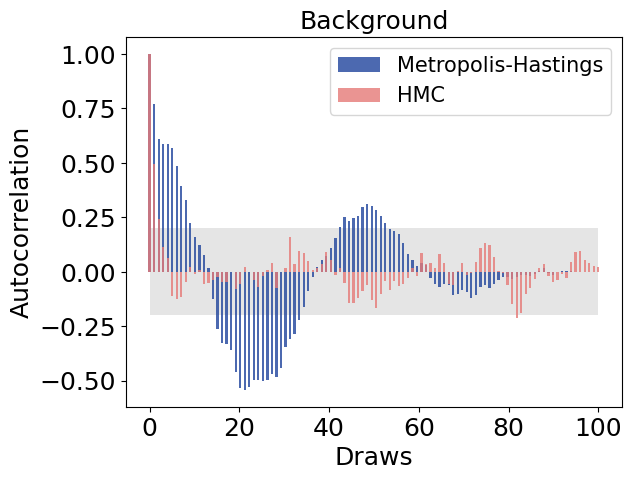

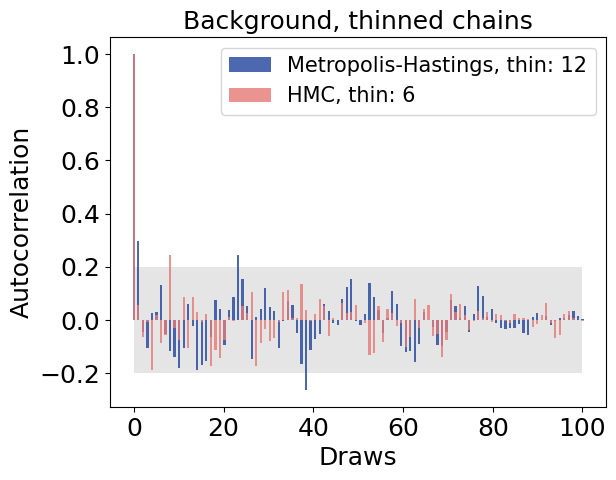

In [8]:
fig = plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_MH), width=0.5, alpha=0.8, color=blue, label='Metropolis-Hastings')
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_NUTS), width=0.5, alpha=0.8, color=orange, label='HMC')
plt.fill_between(np.linspace(0, 100, 100), -0.2, 0.2, color='grey', alpha=0.2, zorder=0, linewidth=0)
plt.xlabel('Draws')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Background')
plt.show()


plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_MH_thinned), width=0.5, alpha=0.8, color=blue, label='Metropolis-Hastings, thin: 12')
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_NUTS_thinned), width=0.5, alpha=0.8, color=orange, label='HMC, thin: 6')
plt.fill_between(np.linspace(0, 100, 100), -0.2, 0.2, color='grey', alpha=0.2, zorder=0, linewidth=0)
plt.xlabel('Draws')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Background, thinned chains');